In [2]:
from google.colab import files
uploaded = files.upload()

Saving student-por.csv to student-por.csv


In [3]:
import pandas as pd
import io
d = pd.read_csv(io.BytesIO(uploaded['student-por.csv']), sep=';')

In [4]:
# load dataset (student Portuguese scores)
#import pandas as pd
#d = pd.read_csv('student-por.csv', sep=';')
len(d)

649

In [5]:
# generate binary label (pass/fail) based on G1+G2+G3 (test grades, each 0-20 pts); threshold for passing is sum>=35
d['pass'] = d.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0, axis=1)
d = d.drop(['G1', 'G2', 'G3'], axis=1)
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,1


In [6]:
# use one-hot encoding on categorical columns
d = pd.get_dummies(d, columns=['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 
                               'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                               'nursery', 'higher', 'internet', 'romantic'])
d.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,pass,sex_F,sex_M,school_GP,school_MS,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,3,3,6,1,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,1,5,0,1,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0


In [7]:
# shuffle rows
d = d.sample(frac=1)
# split training and testing data
d_train = d[:500]
d_test = d[500:]

d_train_att = d_train.drop(['pass'], axis=1)
d_train_pass = d_train['pass']

d_test_att = d_test.drop(['pass'], axis=1)
d_test_pass = d_test['pass']

d_att = d.drop(['pass'], axis=1)
d_pass = d['pass']

# number of passing students in whole dataset:
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(d_pass), len(d_pass), 100*float(np.sum(d_pass)) / len(d_pass)))

Passing: 328 out of 649 (50.54%)


In [8]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
t = t.fit(d_train_att, d_train_pass)

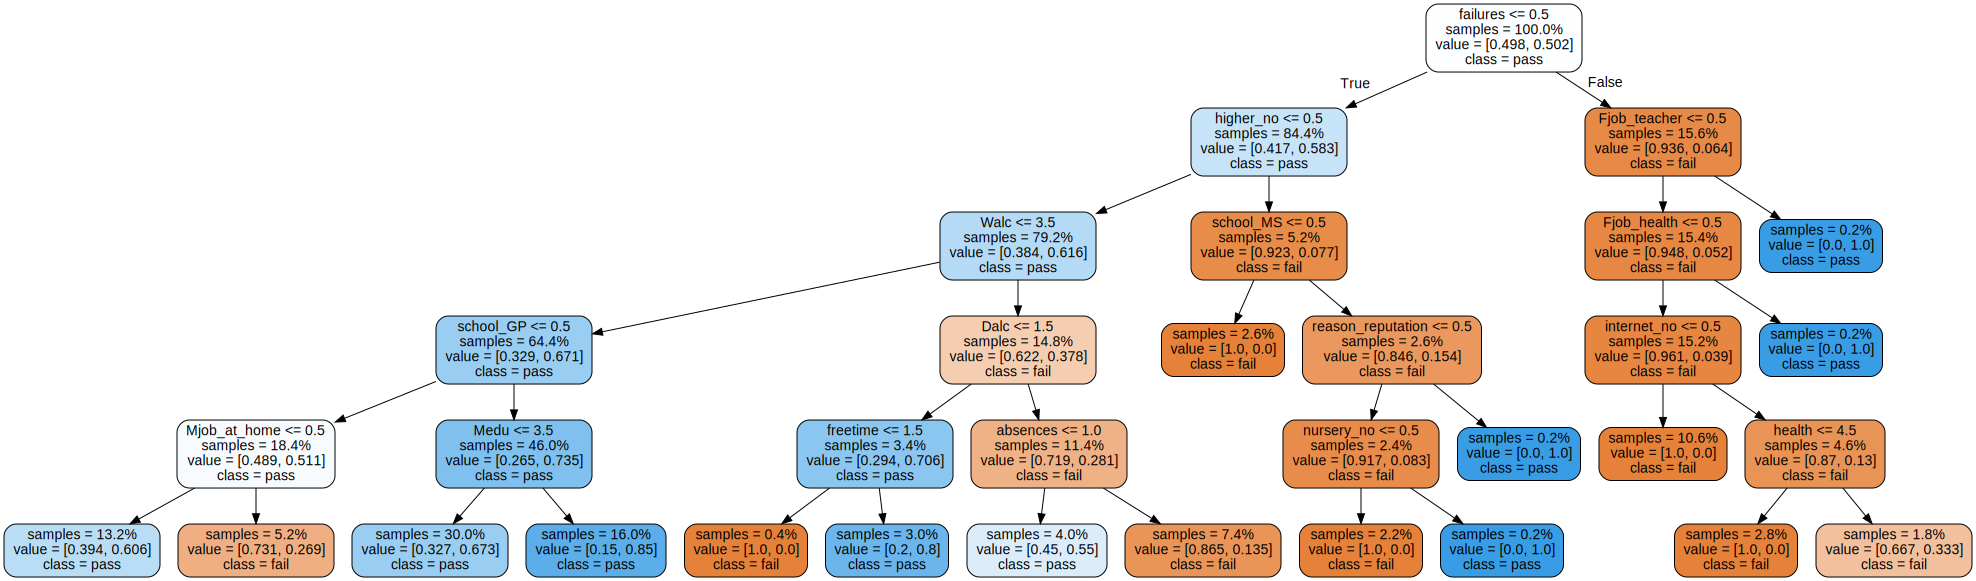

In [9]:
# visualize tree
import graphviz
dot_data = tree.export_graphviz(t, out_file=None, label="all", impurity=False, proportion=True,
                                feature_names=list(d_train_att), class_names=["fail", "pass"], 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [10]:
# save tree
tree.export_graphviz(t, out_file="student-performance.dot", label="all", impurity=False, proportion=True,
                     feature_names=list(d_train_att), class_names=["fail", "pass"], 
                     filled=True, rounded=True)

In [11]:
t.score(d_test_att, d_test_pass)


0.7114093959731543

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

scores = cross_val_score(t, d_test_att, d_test_pass, cv=5)
predict = t.predict(d_test_att)
true_label = d_test_pass.to_numpy()

conf_mat = confusion_matrix(true_label, predict)
print(conf_mat)
scores = cross_val_score(t, d_att, d_pass, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

[[38 34]
 [ 9 68]]
Accuracy: 0.69 (+/- 0.05)
[0.64615385 0.68461538 0.68461538 0.71538462 0.69767442]


In [13]:
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, d_att, d_pass, cv=5)
    print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std() * 2))

Max depth: 1, Accuracy: 0.62 (+/- 0.05)
Max depth: 2, Accuracy: 0.69 (+/- 0.04)
Max depth: 3, Accuracy: 0.69 (+/- 0.05)
Max depth: 4, Accuracy: 0.69 (+/- 0.07)
Max depth: 5, Accuracy: 0.69 (+/- 0.05)
Max depth: 6, Accuracy: 0.68 (+/- 0.08)
Max depth: 7, Accuracy: 0.66 (+/- 0.05)
Max depth: 8, Accuracy: 0.68 (+/- 0.05)
Max depth: 9, Accuracy: 0.68 (+/- 0.03)
Max depth: 10, Accuracy: 0.66 (+/- 0.04)
Max depth: 11, Accuracy: 0.68 (+/- 0.04)
Max depth: 12, Accuracy: 0.68 (+/- 0.03)
Max depth: 13, Accuracy: 0.68 (+/- 0.03)
Max depth: 14, Accuracy: 0.66 (+/- 0.07)
Max depth: 15, Accuracy: 0.67 (+/- 0.05)
Max depth: 16, Accuracy: 0.65 (+/- 0.05)
Max depth: 17, Accuracy: 0.67 (+/- 0.05)
Max depth: 18, Accuracy: 0.68 (+/- 0.03)
Max depth: 19, Accuracy: 0.66 (+/- 0.05)


In [14]:
depth_acc = np.empty((19,3), float)
i = 0
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, d_att, d_pass, cv=5)
    depth_acc[i,0] = max_depth
    depth_acc[i,1] = scores.mean()
    depth_acc[i,2] = scores.std() * 2
    i += 1
    
depth_acc

array([[ 1.        ,  0.61941562,  0.04615977],
       [ 2.        ,  0.68720334,  0.04434137],
       [ 3.        ,  0.69028026,  0.05477845],
       [ 4.        ,  0.69183065,  0.06673339],
       [ 5.        ,  0.68725104,  0.05111801],
       [ 6.        ,  0.67485987,  0.0814429 ],
       [ 7.        ,  0.66721527,  0.06842001],
       [ 8.        ,  0.67488372,  0.0562137 ],
       [ 9.        ,  0.66721527,  0.04711433],
       [10.        ,  0.65946333,  0.04096787],
       [11.        ,  0.68257603,  0.04318982],
       [12.        ,  0.66870602,  0.02258474],
       [13.        ,  0.68719141,  0.04252194],
       [14.        ,  0.68722719,  0.02208716],
       [15.        ,  0.6918068 ,  0.02107987],
       [16.        ,  0.6856291 ,  0.03445331],
       [17.        ,  0.67485987,  0.02928819],
       [18.        ,  0.65484794,  0.04915229],
       [19.        ,  0.66870602,  0.02644654]])

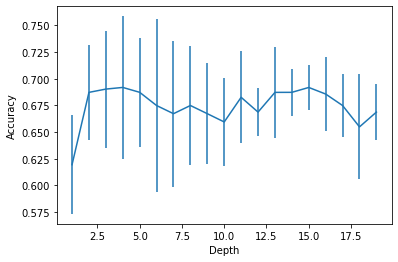

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr=depth_acc[:,2])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Depth')
plt.show()

Confusion matrix, without normalization
[[38 34]
 [ 9 68]]
[0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0
 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0
 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1
 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1
 1]
77


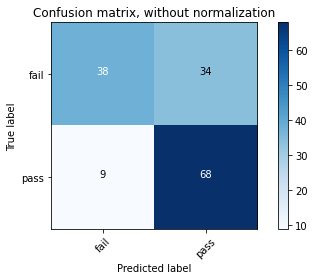

In [23]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(true_label, predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fail','pass'],
                      title='Confusion matrix, without normalization')
print(true_label)
print(sum(true_label))

In [32]:
#optional
# shuffle rows
d = d.sample(frac=1)
# split training and testing data
d_train2 = d[:600]
d_test2 = d[600:]

d_train_att2 = d_train2.drop(['pass'], axis=1)
d_train_pass2 = d_train2['pass']

d_test_att2 = d_test2.drop(['pass'], axis=1)
d_test_pass2 = d_test2['pass']

d_att2 = d.drop(['pass'], axis=1)
d_pass2 = d['pass']

# number of passing students in whole dataset:
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(d_pass2), len(d_pass2), 100*float(np.sum(d_pass2)) / len(d_pass2)))

Passing: 328 out of 649 (50.54%)


In [34]:
# fit a decision tree
from sklearn import tree
t2 = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4)
t2 = t2.fit(d_train_att2, d_train_pass2)


[[18 11]
 [ 3 17]]
Accuracy: 0.70 (+/- 0.06)
[0.68 0.68 0.73 0.66 0.74]
Confusion matrix, without normalization
[[18 11]
 [ 3 17]]
[1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0
 0 0 0 1 0 0 0 0 1 0 0 1]
20


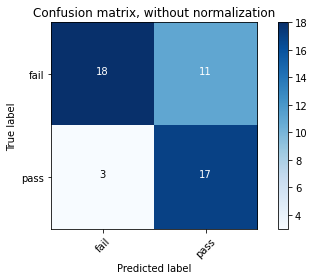

In [35]:
scores = cross_val_score(t2, d_test_att2, d_test_pass2, cv=5)
predict2 = t2.predict(d_test_att2)
true_label2 = d_test_pass2.to_numpy()

conf_mat2 = confusion_matrix(true_label2, predict2)
print(conf_mat2)
scores2 = cross_val_score(t2, d_att2, d_pass2, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print(scores2)
cnf_matrix = confusion_matrix(true_label2, predict2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fail','pass'],
                      title='Confusion matrix, without normalization')
print(true_label2)
print(sum(true_label2))

1. I put more students for the training.
2. I reduced depth to 4, according to the result of 'depth_acc'.